In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt

REAL_PATH = "../data_fakenewsnet/raw/politifact/politifact_real.csv"
FAKE_PATH = "../data_fakenewsnet/raw/politifact/politifact_fake.csv"

OUT_DIR = "../outputs/fakenewsnet_metadata"
os.makedirs(OUT_DIR, exist_ok=True)

In [2]:
real_df = pd.read_csv(REAL_PATH)
fake_df = pd.read_csv(FAKE_PATH)

real_df["label"] = 0
fake_df["label"] = 1

df = pd.concat([real_df, fake_df], ignore_index=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Label counts:\n", df["label"].value_counts())
df.head()


Shape: (1056, 5)
Columns: ['id', 'news_url', 'title', 'tweet_ids', 'label']
Label counts:
 label
0    624
1    432
Name: count, dtype: int64


,id,news_url,title,tweet_ids,label
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,0
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,0
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,0
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,0
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,0


In [3]:
def tweet_count(x):
    if pd.isna(x):
        return 0
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return 0
    # FakeNewsNet CSV often stores tweet IDs separated by \t
    return len([t for t in s.split("\t") if t.strip()])

df["tweet_count"] = df["tweet_ids"].apply(tweet_count)
df["has_tweets"] = (df["tweet_count"] > 0).astype(int)
df["log_tweet_count"] = np.log1p(df["tweet_count"])

X = df[["tweet_count", "has_tweets", "log_tweet_count"]]
y = df["label"]

print(X.describe())
print("Missing rows in X:", X.isna().sum())


        tweet_count   has_tweets  log_tweet_count
count   1056.000000  1056.000000      1056.000000
mean     552.571970     0.758523         3.363832
std     2126.317823     0.428182         2.704599
min        0.000000     0.000000         0.000000
25%        1.000000     1.000000         0.693147
50%       30.000000     1.000000         3.433987
75%      246.250000     1.000000         5.510398
max    29060.000000     1.000000        10.277152
Missing rows in X: tweet_count        0
has_tweets         0
log_tweet_count    0
dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6415094339622641
              precision    recall  f1-score   support

           0      0.687     0.720     0.703       125
           1      0.568     0.529     0.548        87

    accuracy                          0.642       212
   macro avg      0.627     0.624     0.625       212
weighted avg      0.638     0.642     0.639       212

Confusion matrix:
 [[90 35]
 [41 46]]


In [5]:
y_proba = clf.predict_proba(X_test)[:, 1]

def eval_threshold(thresh: float):
    y_pred_t = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    return {
        "threshold": thresh,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
results = pd.DataFrame([eval_threshold(t) for t in thresholds])

results.to_csv(os.path.join(OUT_DIR, "threshold_results.csv"), index=False)
results


,threshold,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.419811,0.414286,1.000000,0.585859,87,123,2,0
1,0.2,0.594340,0.503311,0.873563,0.638655,76,75,50,11
2,0.3,0.599057,0.506667,0.873563,0.641350,76,74,51,11
3,0.4,0.599057,0.506667,0.873563,0.641350,76,74,51,11
4,0.5,0.641509,0.567901,0.528736,0.547619,46,35,90,41
5,0.6,0.589623,0.000000,0.000000,0.000000,0,0,125,87
6,0.7,0.589623,0.000000,0.000000,0.000000,0,0,125,87
7,0.8,0.589623,0.000000,0.000000,0.000000,0,0,125,87
8,0.9,0.589623,0.000000,0.000000,0.000000,0,0,125,87


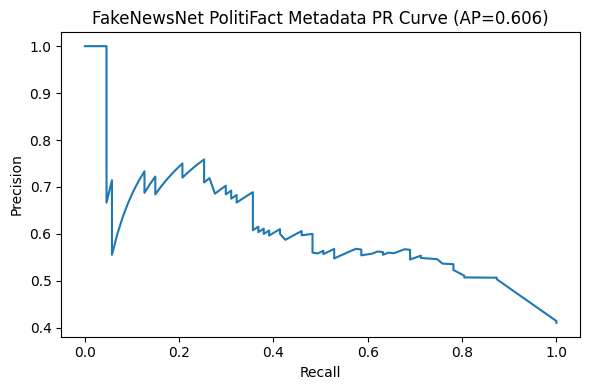

Average Precision (AP): 0.6063641378113861


In [6]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"FakeNewsNet PolitiFact Metadata PR Curve (AP={ap:.3f})")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pr_curve.png"), dpi=200)
plt.show()

print("Average Precision (AP):", ap)


Conclusion:

This notebook trains a metadata-only model on the FakeNewsNet PolitiFact dataset using diffusion related signals derived from the presence and volume of tweet activity (e.g., whether an article has associated tweets and how many). Performance is evaluated using standard classification metrics, a threshold analysis table, and a precision–recall curve.

This model isolates what can be predicted from metadata alone, without using any article text. The results serve as a baseline for comparing (1) the text-only model and (2) the final hybrid model that combines both article content and social context.
